In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout
from keras.optimizers import Adam ,RMSprop
from keras import  backend as K

2023-08-03 23:09:09.531748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
# import dataset
from keras.datasets import mnist


# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data() # Not needed for our scenario just getting familiar with the commands

2023-08-03 22:12:57.399269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


11490434/11490434 [==============================] - 3s 0us/step


In [2]:
dataset_dir = "../Pytorch_Project/UpdatedDataset/data/"
image_size = (180,180)
batch_size = 128

train_ds, vald_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split = 0.2,
    subset = "both",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)


Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


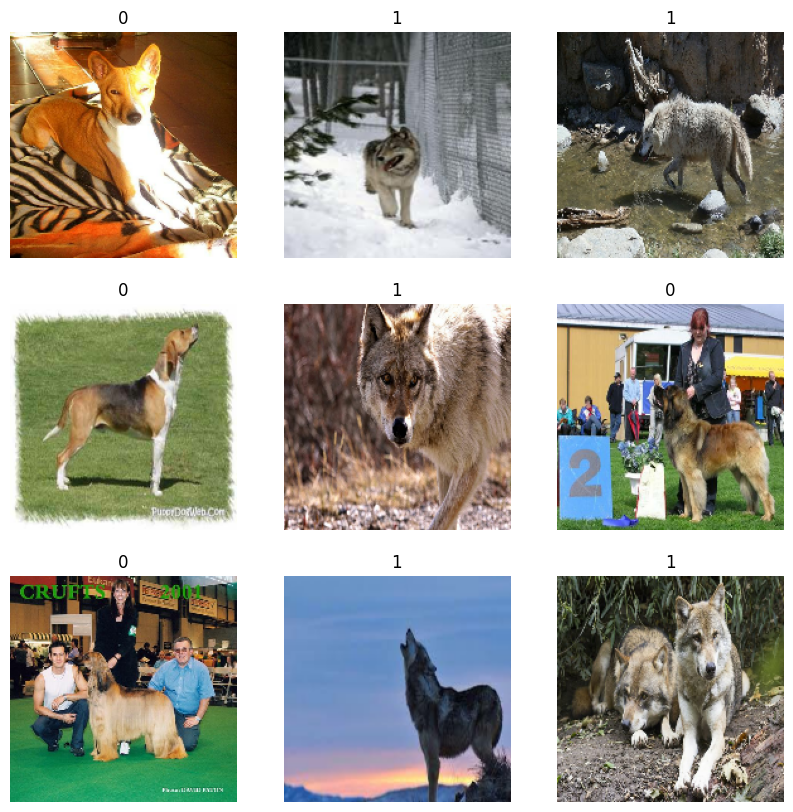

In [3]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
#Data augmentation is done to explore more aspects of the input data
data_augmentation = Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [5]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
vald_ds = vald_ds.prefetch(tf.data.AUTOTUNE)

In [6]:
def forward(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Initial layer
    x = keras.layers.Rescaling(1.0/255)(inputs)
    x = keras.layers.Conv2D(128,3,strides=2,padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x

    for size in [256,512,728]:
        x = Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size,3,padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size,3,padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides = 2,padding="same")(x)

        # Residual
        residual = keras.layers.Conv2D(size,1,strides=2, padding="same")(previous_block_activation)

        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual


    x = keras.layers.SeparableConv2D(1028,3,padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units, activation = activation)(x)
    return keras.Model(inputs, outputs) 


model = forward(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True) # To visualize the flow

In [7]:
# Train the model
epochs = 20

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),]
model.compile(
    optimizer = Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=vald_ds,
)


Epoch 1/20
13/13 [==============================] - 432s 32s/step - loss: 0.6984 - accuracy: 0.6413 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/20
13/13 [==============================] - 435s 33s/step - loss: 0.5616 - accuracy: 0.7237 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 3/20
 3/13 [=====>........................] - ETA: 6:01 - loss: 0.5068 - accuracy: 0.7552

In [ ]:
img = keras.utils.load_img(
    dataset_dir+"/Dog/n02085936_8507.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% Wolf and {100 * score:.2f}% Dog.")